In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import math
import matplotlib.pyplot as plt
from pprint import pprint
sb.set()
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pathlib import Path

In [2]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected=True)

In [3]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os

Using TensorFlow backend.


In [4]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

<h1><font color=blue><fontsize: 45pt><center>Stock VS Happiness</center></h1>

In [5]:
print("Agenda: We explore the relationship between stock & happiness in individual countries based on the Stocks index of the\ncountries and their happiness level.")

Agenda: We explore the relationship between stock & happiness in individual countries based on the Stocks index of the
countries and their happiness level.


![World Map](Images/World_map.png)

In [6]:
d1 = pd.read_excel("Data/World Happiness Report/WHR2019.xlsx", sheet_name='Table2.1')
data=d1.rename(columns={'Country name':'Country', 
                      'Life Ladder':'Happiness',
                      'Log GDP per capita':'LogGDP',
                      'Healthy life expectancy at birth':'Life_expectancy',
                      'Freedom to make life choices': 'Freedom',
                      'Positive affect':'Pos_affect',
                      'Negative affect':'Neg_affect',
                      'GINI index (World Bank estimate)':'GINI',
                      'GINI index (World Bank estimate), average 2000-16':'GINI_average',
                      'gini of household income reported in Gallup, by wp5-year':'GINI_householdincome',
                       })
data = data.iloc[:,0:20]
data = data.drop(['GINI','GINI_average', 'Most people can be trusted, Gallup'], axis=1)

Intercept of Regression 	: b =  [4.93042161]
Coefficients of Regression 	: a =  [[ 7.12952553e-02  3.06251287e-01 -3.54056262e-03  2.00116400e-01
   3.78958421e-01 -1.02680416e+00  5.49369539e-01  6.50784371e-01
  -3.65497567e-01  2.77760485e-02  9.28514978e-02  1.94609393e+00
  -9.95834694e+00  6.92460401e-02]]

                                           Predictors  Coefficients
0                                              LogGDP      0.071295
1                                      Social support      0.306251
2                                     Life_expectancy     -0.003541
3                                             Freedom      0.200116
4                                          Generosity      0.378958
5                           Perceptions of corruption     -1.026804
6                                          Pos_affect      0.549370
7                                          Neg_affect      0.650784
8                   Confidence in national government     -0.365498
9    

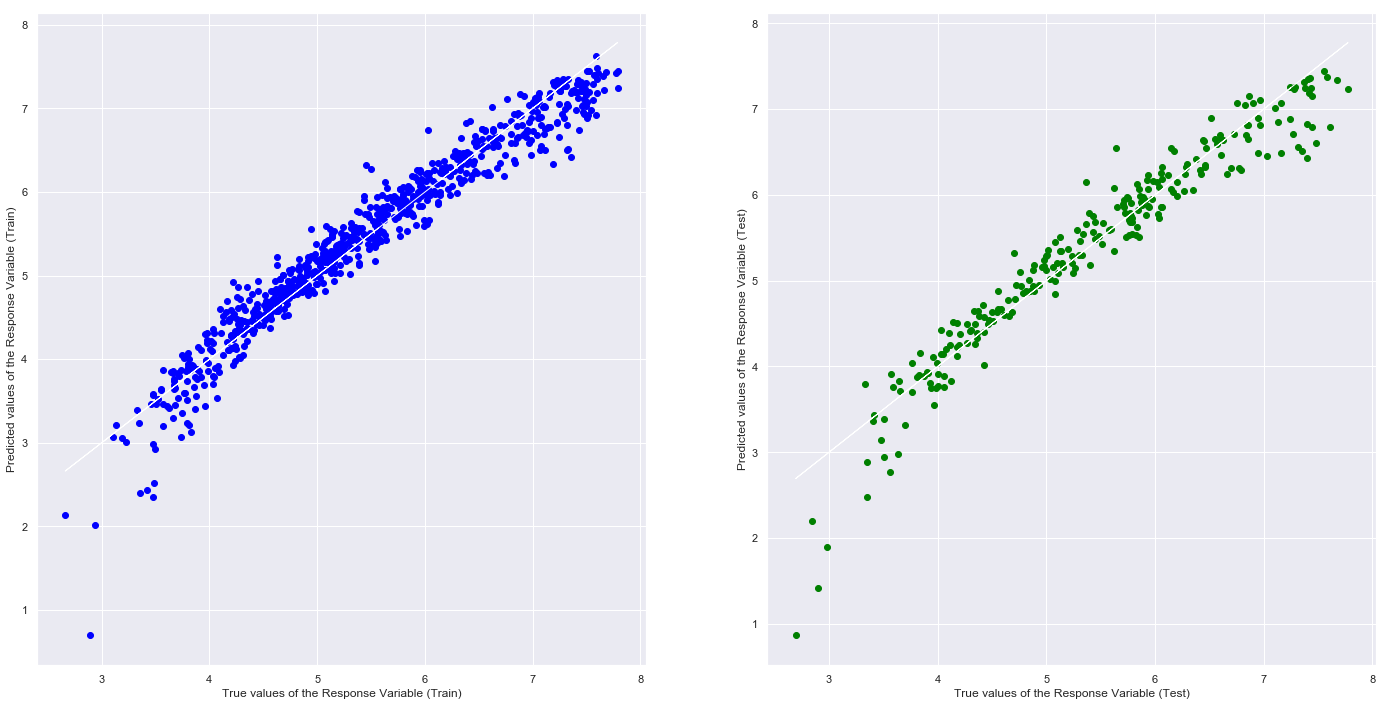

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.9472832302115132
Mean Squared Error (MSE) 	: 0.06986589985582141

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.9252541449848044
Mean Squared Error (MSE) 	: 0.10443554143527915



In [7]:
data = data.dropna()
# Extract Response and Predictors
y = pd.DataFrame(data["Happiness"])
X = pd.DataFrame(data[['LogGDP', 'Social support',
                       'Life_expectancy', 'Freedom', 'Generosity', 'Perceptions of corruption',
                       'Pos_affect', 'Neg_affect', 'Confidence in national government',
                       'Democratic Quality', 'Delivery Quality',
                       'Standard deviation of ladder by country-year',
                       'Standard deviation/Mean of ladder by country-year',
                       'GINI_householdincome']])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
print(pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"]))
print()

# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

In [8]:
def exponential_smoothing_plot(train_index, train_avg, test_index, test_avg, y_hat_index, y_hat):
    trace = go.Scatter(
        x = train_index,
        y = train_avg,
        name='Train')
    trace2 = go.Scatter(
        x = test_index,
        y = test_avg,
        name='Test')
    trace3 = go.Scatter(
        x = y_hat_index,
        y = y_hat,
        name='Holt Winter')
    data = [trace, trace2, trace3]
    iplot(data)

In [9]:
def interploation_1d(life_ladder_data, no_of_years, no_of_days, power):
    num = range(0, no_of_years)
    x = np.array(tuple(num))
    y = np.array(life_ladder_data)
    z = np.polyfit(x, y, power)
    f = np.poly1d(z)
    num_1 = no_of_years - 1
    x_new = np.linspace(0, num_1, no_of_days)
    y_new = f(x_new)
    print("The interpolated y-values are:\n", y_new)
    print("Total:", len(y_new), "datapoints generated for this specific diagram.")
    trace1 = go.Scatter(
        x=x,
        y=y,
        mode='markers',
        name='Data',
        marker=dict(
            size=12))
    trace2 = go.Scatter(
        x=x_new,
        y=y_new,
        mode='lines',
        name='Fit')
    annotation = go.Annotation(
        x=1,
        y=1,
        showarrow=False)
    layout = go.Layout(title='Polynomial Fit in Python',
                       annotations=[annotation])
    data = [trace1, trace2]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
    return y_new

def interploation_1d_custom(life_ladder_data, no_of_years, no_of_days, power, avg_data):
    num = range(0, no_of_years)
    x = np.array(tuple(num))
    y = np.array(life_ladder_data)
#     y2 = np.array(avg_data)
    z = np.polyfit(x, y, power)
    f = np.poly1d(z)
    num_1 = no_of_years - 1
    x_new = np.linspace(0, num_1, no_of_days)
    y_new = f(x_new)
    print("The interpolated y-values are:\n", y_new)
    print("Total:", len(y_new), "datapoints generated for this specific diagram.")
    trace1 = go.Scatter(
        x=x,
        y=y,
        mode='markers',
        name='Data',
        marker=dict(
            size=12,
            color = 'red'))
    trace2 = go.Scatter(
        x=x_new,
        y=y_new,
        mode='lines',
        name='Fit')
    trace3 = go.Scatter(
        x=x,
        y=avg_data,
        mode='markers',
        name='Average',
        marker=dict(
            size=12,
            color = 'green'))
    annotation = go.Annotation(
        x=1,
        y=1,
        showarrow=False)
    layout = go.Layout(title='Polynomial Fit in Python',
                       annotations=[annotation])
    data = [trace1, trace3, trace2]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
    return y_new

In [10]:
def stocks_data_1(data):
    data["Log10_volume"] = np.log10(data['Volume'])
    data["Average"] = (data["High"] + data["Low"])/2
    data["Perc Diff"] = ((data['High']-data['Low'])/data['High'])*100
    data["Delta"] = ((data['High']-data['Low']))
    
    Stocks_2006 = pd.DataFrame(data[data['Date'].str.contains('/2006')])
    Stocks_2007 = pd.DataFrame(data[data['Date'].str.contains('/2007')])
    Stocks_2008 = pd.DataFrame(data[data['Date'].str.contains('/2008')])
    Stocks_2009 = pd.DataFrame(data[data['Date'].str.contains('/2009')])
    Stocks_2010 = pd.DataFrame(data[data['Date'].str.contains('/2010')])
    Stocks_2011 = pd.DataFrame(data[data['Date'].str.contains('/2011')])
    Stocks_2012 = pd.DataFrame(data[data['Date'].str.contains('/2012')])
    Stocks_2013 = pd.DataFrame(data[data['Date'].str.contains('/2013')])
    Stocks_2014 = pd.DataFrame(data[data['Date'].str.contains('/2014')])
    Stocks_2015 = pd.DataFrame(data[data['Date'].str.contains('/2015')])
    Stocks_2016 = pd.DataFrame(data[data['Date'].str.contains('/2016')])
    Stocks_2017 = pd.DataFrame(data[data['Date'].str.contains('/2017')])
    Stocks_2018 = pd.DataFrame(data[data['Date'].str.contains('/2018')])
    
    frames = [Stocks_2006, Stocks_2007, Stocks_2008, Stocks_2009, Stocks_2010, Stocks_2011, Stocks_2012, Stocks_2013,
              Stocks_2014, Stocks_2015, Stocks_2016, Stocks_2017, Stocks_2018]
    
    Resulting_Data = pd.concat(frames)
    print("Total number of days:", len(Resulting_Data))
    return Resulting_Data

def stocks_data_2(data):
    data["Log10_volume"] = np.log10(data['Volume'])
    data["Average"] = (data["High"] + data["Low"])/2
    data["Perc Diff"] = ((data['High']-data['Low'])/data['High'])*100
    data["Delta"] = ((data['High']-data['Low']))
    
    Stocks_2006 = pd.DataFrame(data[data['Date'].str.contains('2006-')])
    Stocks_2007 = pd.DataFrame(data[data['Date'].str.contains('2007-')])
    Stocks_2008 = pd.DataFrame(data[data['Date'].str.contains('2008-')])
    Stocks_2009 = pd.DataFrame(data[data['Date'].str.contains('2009-')])
    Stocks_2010 = pd.DataFrame(data[data['Date'].str.contains('2010-')])
    Stocks_2011 = pd.DataFrame(data[data['Date'].str.contains('2011-')])
    Stocks_2012 = pd.DataFrame(data[data['Date'].str.contains('2012-')])
    Stocks_2013 = pd.DataFrame(data[data['Date'].str.contains('2013-')])
    Stocks_2014 = pd.DataFrame(data[data['Date'].str.contains('2014-')])
    Stocks_2015 = pd.DataFrame(data[data['Date'].str.contains('2015-')])
    Stocks_2016 = pd.DataFrame(data[data['Date'].str.contains('2016-')])
    Stocks_2017 = pd.DataFrame(data[data['Date'].str.contains('2017-')])
    Stocks_2018 = pd.DataFrame(data[data['Date'].str.contains('2018-')])
    
    frames = [Stocks_2006, Stocks_2007, Stocks_2008, Stocks_2009, Stocks_2010, Stocks_2011, Stocks_2012, Stocks_2013,
              Stocks_2014, Stocks_2015, Stocks_2016, Stocks_2017, Stocks_2018]
    
    Resulting_Data = pd.concat(frames)
    print("Total number of days:", len(Resulting_Data))
    return Resulting_Data

In [11]:
def combine_the_data_Stocks_n_LL(StocksData, NyrLLData):
    StocksData.reset_index(drop=True)
    StocksData.index = np.arange(1, len(StocksData)+1)
    NyrLLData.reset_index(drop=True)
    NyrLLData.index = np.arange(1, len(StocksData)+1)
    combine = StocksData.join(NyrLLData)
    
    trace = go.Scatter(
        x = combine['Date'],
        y = combine['Happiness'])
    data = [trace]
    iplot(data)
    
    return pd.DataFrame(combine)

In [12]:
# Functions for Graph and Metrics
# Input: model, x_train, y_train, x_test, y_test, scaler
# prints: metrics and graph

def plotly_graph(model=None, dataset=None):
    df = dataset[['Average', 'Happiness']].values
    df = df.reshape(-1, 2)
    
    lookback = 50
    
    dataset_train = np.array(df[:int(df.shape[0]*0.8)])
    dataset_test = np.array(df[int(df.shape[0]*0.8)-lookback:])

    scaler = MinMaxScaler(feature_range=(0,1))
    dataset_train = scaler.fit_transform(dataset_train)
    dataset_test = scaler.transform(dataset_test) 

    x_train, y_train = create_dataset_2features(dataset_train)
    x_test, y_test = create_dataset_2features(dataset_test)

#     x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))
#     x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2)) 
    
    df = dataset['Average'].values
    df = df.reshape(-1, 1)

    dataset_train = np.array(df[:int(df.shape[0]*0.8)])
    dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])

    scaler1D = MinMaxScaler(feature_range=(0,1))
    dataset_train = scaler1D.fit_transform(dataset_train)
    dataset_test = scaler1D.transform(dataset_test)
    
    y_test_scaled = scaler1D.inverse_transform(y_test.reshape(-1, 1))
    
    some_range = range(len(y_train)+50,len(y_train)+50+len(predictions))
    delta_change = y_test_scaled - predictions
    
    temp_list_1 = []
    temp_list_2 = []
    for i in some_range:
        temp_list_1.append(i)
    for i in predictions:
        temp_list_2.append(i[0])
    trace1 = go.Scatter(
        x = dataset['Average'].index,
        y = dataset['Average'].values,
        name = 'True Price')
    trace2 = go.Scatter(
        x = temp_list_1,
        y = temp_list_2,
        name = 'Predicted Price')
    data = [trace1, trace2]
    iplot(data)
    
    temp_list_3 = []
    temp_list_4 = []
    count=0
    for n in y_test_scaled:
        count += 1
        temp_list_3.append(count)
        temp_list_4.append(n[0])
    trace3 = go.Scatter(
        x = temp_list_3,
        y = temp_list_4,
        name = 'True Testing Price')
    trace4 = go.Scatter(
        x = temp_list_3,
        y = temp_list_2,
        name = 'Predicted Testing Price')
    data2 = [trace3, trace4]
    iplot(data2)
    print("Percentage Change in Stock Prices")
    temp_list_5 = []
    for j in delta_change:
        temp_list_5.append(j[0])
    trace5 = go.Scatter(
        x = temp_list_1,
        y = temp_list_5)
    data3 = [trace5]
    iplot(data3)

In [13]:
# Functions for Graph and Metrics
# Input: model, x_train, y_train, x_test, y_test, scaler
# prints: metrics and graph

def metrics_and_graph_interactive(model=None, x_train=None, y_train=None, x_test=None, y_test=None, feature=None, dataset=None):
    df = dataset['Average'].values
    df = df.reshape(-1, 1)

    dataset_train = np.array(df[:int(df.shape[0]*0.8)])
    dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])


    scaler1D = MinMaxScaler(feature_range=(0,1))
    dataset_train = scaler1D.fit_transform(dataset_train)
    dataset_test = scaler1D.transform(dataset_test)
    
    # metrics = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']
    model_metric = ['MSE', 'MAE', 'MAPE', 'CP']

    score = model.evaluate(x_test, y_test, verbose=1)
    for i in range(len(model_metric)):
        if i==0:
            print()
        print(model_metric[i] + ":\t", score[i])
    
    
    df = dataset['Average'].values
    
    predictions = model.predict(x_test)
    predictions = scaler1D.inverse_transform(predictions)

#     fig, ax = plt.subplots(figsize=(8,4))
#     plt.title("Average Stock Price Prediction using " + feature)
#     plt.xlabel("Time (oldest -> latest)")
#     plt.plot(df, color='red',  label="True Price")
#     ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions, color='blue', label='Predicted Testing Price')
#     plt.legend()
    y_test_scaled = scaler1D.inverse_transform(y_test.reshape(-1, 1))
    
    some_range = range(len(y_train)+50,len(y_train)+50+len(predictions))

    delta_change = y_test_scaled - predictions
    
    temp_list_1 = []
    temp_list_2 = []
    for i in some_range:
        temp_list_1.append(i)
    for i in predictions:
        temp_list_2.append(i[0])
    trace1 = go.Scatter(
        x = dataset['Average'].index,
        y = dataset['Average'].values,
        name = 'True Price')
    trace2 = go.Scatter(
        x = temp_list_1,
        y = temp_list_2,
        name = 'Predicted Price')
    data = [trace1, trace2]
    iplot(data)
    
    temp_list_3 = []
    temp_list_4 = []
    count=0
    for n in y_test_scaled:
        count += 1
        temp_list_3.append(count)
        temp_list_4.append(n[0])
    trace3 = go.Scatter(
        x = temp_list_3,
        y = temp_list_4,
        name = 'True Testing Price')
    trace4 = go.Scatter(
        x = temp_list_3,
        y = temp_list_2,
        name = 'Predicted Testing Price')
    data2 = [trace3, trace4]
    iplot(data2)
    print("Percentage Change in Stock Prices")
    temp_list_5 = []
    for j in delta_change:
        temp_list_5.append(j[0])
    trace5 = go.Scatter(
        x = temp_list_1,
        y = temp_list_5)
    data3 = [trace5]
    iplot(data3)

#     fig, ax = plt.subplots(figsize=(8,4))
#     plt.title("Zoom in (test predictions)")
#     plt.xlabel("Time (oldest -> latest)")
#     ax.plot(y_test_scaled, color='red', label='True Testing Price')
#     plt.plot(predictions, color='blue', label='Predicted Testing Price')
#     plt.legend()

#     delta = y_test_scaled - predictions

#     fig, ax = plt.subplots(figsize=(8,4))
#     plt.title("Delta (y_test - predictions)")
#     plt.xlabel("Time (oldest -> latest)")
#     ax.plot(delta, color='green', label='Delta')
#     plt.legend()

# US Region Happiness & Happiness [S&P 500 (^GSPC)]

![USA Flag](Images/USA.png)

In [14]:
Stocks_US = pd.read_csv('Data\Stocks\S&P 500 (^GSPC)_2005to2018_daily.csv')
Stocks_US["Average"] = (Stocks_US["High"] + Stocks_US["Low"])/2
Stocks_US.head()

Date         Open         High          Low        Close  \
0  31/12/2004  1213.550049  1217.329956  1211.650024  1211.920044   
1    3/1/2005  1211.920044  1217.800049  1200.319946  1202.079956   
2    4/1/2005  1202.079956  1205.839966  1185.390015  1188.050049   
3    5/1/2005  1188.050049  1192.729980  1183.719971  1183.739990   
4    6/1/2005  1183.739990  1191.630005  1183.270020  1187.890015   

     Adj Close      Volume      Average  
0  1211.920044   786900000  1214.489990  
1  1202.079956  1510800000  1209.059998  
2  1188.050049  1721000000  1195.614990  
3  1183.739990  1738900000  1188.224976  
4  1187.890015  1569100000  1187.450012

### Interpolation to get the Happiness

In [15]:
US_Data =  pd.DataFrame(d1[(d1['Country name'] == "United States")])
US_Data_LL = list(US_Data['Life Ladder'])

x = np.array(tuple(range(0,13)))
y = np.array(US_Data_LL)
z = np.polyfit(x, y, 10)
f = np.poly1d(z)
x_new = np.linspace(0, 12, 3270)
y_new = f(x_new)

print("The interpolated y-values are:\n", y_new)
print("Total:", len(y_new), "datapoints generated for this specific diagram.")
trace1 = go.Scatter(
    x=x,
    y=y,
    mode='markers',
    name='Data',
    marker=dict(
        size=12))
trace2 = go.Scatter(
    x=x_new,
    y=y_new,
    mode='lines',
    name='Fit')
annotation = go.Annotation(
    x=1,
    y=1,
    showarrow=False)
layout = go.Layout(title='Polynomial Fit in Python',
                   annotations=[annotation])
data = [trace1, trace2]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

The interpolated y-values are:
 [7.18180613 7.17978597 7.1778512  ... 6.87096547 6.87679398 6.8827565 ]
Total: 3270 datapoints generated for this specific diagram.


C:\Users\tkjie\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:144: DeprecationWarning:

plotly.graph_objs.Annotation is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Annotation
  - plotly.graph_objs.layout.scene.Annotation




In [16]:
Values_for_13yr = pd.DataFrame({'Happiness': y_new})
Values_for_13yr.head()

Stocks_US_2006 = pd.DataFrame(Stocks_US[Stocks_US['Date'].str.contains('/2006')])
Stocks_US_2007 = pd.DataFrame(Stocks_US[Stocks_US['Date'].str.contains('/2007')])
Stocks_US_2008 = pd.DataFrame(Stocks_US[Stocks_US['Date'].str.contains('/2008')])
Stocks_US_2009 = pd.DataFrame(Stocks_US[Stocks_US['Date'].str.contains('/2009')])
Stocks_US_2010 = pd.DataFrame(Stocks_US[Stocks_US['Date'].str.contains('/2010')])
Stocks_US_2011 = pd.DataFrame(Stocks_US[Stocks_US['Date'].str.contains('/2011')])
Stocks_US_2012 = pd.DataFrame(Stocks_US[Stocks_US['Date'].str.contains('/2012')])
Stocks_US_2013 = pd.DataFrame(Stocks_US[Stocks_US['Date'].str.contains('/2013')])
Stocks_US_2014 = pd.DataFrame(Stocks_US[Stocks_US['Date'].str.contains('/2014')])
Stocks_US_2015 = pd.DataFrame(Stocks_US[Stocks_US['Date'].str.contains('/2015')])
Stocks_US_2016 = pd.DataFrame(Stocks_US[Stocks_US['Date'].str.contains('/2016')])
Stocks_US_2017 = pd.DataFrame(Stocks_US[Stocks_US['Date'].str.contains('/2017')])
Stocks_US_2018 = pd.DataFrame(Stocks_US[Stocks_US['Date'].str.contains('/2018')])

frames = [Stocks_US_2006, Stocks_US_2007, Stocks_US_2008, Stocks_US_2009, Stocks_US_2010, Stocks_US_2011, Stocks_US_2012, 
          Stocks_US_2013, Stocks_US_2014, Stocks_US_2015, Stocks_US_2016, Stocks_US_2017, Stocks_US_2018]
Resulting_Data = pd.concat(frames)

Resulting_Data.reset_index(drop=True)
Resulting_Data.index = np.arange(1, len(Resulting_Data)+1)
Values_for_13yr.reset_index(drop=True)
Values_for_13yr.index = np.arange(1, len(Resulting_Data)+1)
Stocks_US = LLwithStocks = Resulting_Data.join(Values_for_13yr)
Stocks_US.head()

Date         Open         High          Low        Close    Adj Close  \
1  3/1/2006  1248.290039  1270.219971  1245.739990  1268.800049  1268.800049   
2  4/1/2006  1268.800049  1275.369995  1267.739990  1273.459961  1273.459961   
3  5/1/2006  1273.459961  1276.910034  1270.300049  1273.479980  1273.479980   
4  6/1/2006  1273.479980  1286.089966  1273.479980  1285.449951  1285.449951   
5  9/1/2006  1285.449951  1290.780029  1284.819946  1290.150024  1290.150024   

       Volume      Average  Happiness  
1  2554570000  1257.979981   7.181806  
2  2515330000  1271.554993   7.179786  
3  2433340000  1273.605041   7.177851  
4  2446560000  1279.784973   7.176001  
5  2301490000  1287.799988   7.174233

C:\Users\tkjie\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



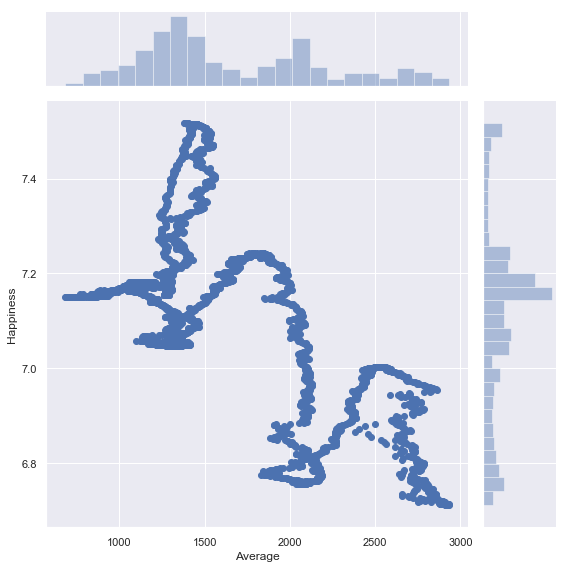

In [17]:
sb.jointplot(Stocks_US['Average'], Values_for_13yr['Happiness'], height = 8)

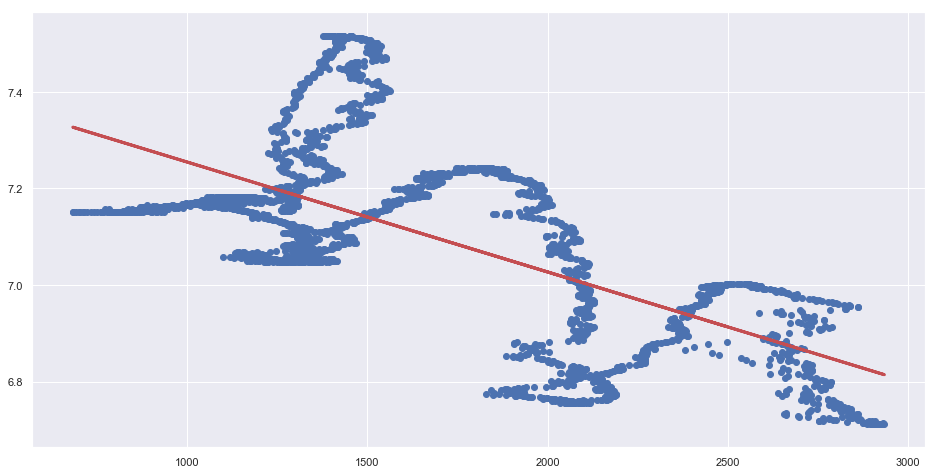

In [18]:
average = pd.DataFrame(Resulting_Data['Average'])
linreg = LinearRegression()
linreg.fit(average, Values_for_13yr) 
regline_x =  average
regline_y = linreg.intercept_ + linreg.coef_ * average

# function to plot the line and scatter plot
# Plot the Linear Regression line
f, axes = plt.subplots(1, 1, figsize=(16, 8))
plt.scatter(Stocks_US['Average'], Stocks_US['Happiness'])
plt.plot(regline_x, regline_y, 'r-', linewidth = 3)
plt.show()

In [19]:
print("Explained Variance (R^2) \t:", linreg.score(average, Stocks_US['Happiness']))

# MSE function is written independently
# Mean Squared Error (MSE)
def mean_sq_err(actual, predicted):
    '''Returns the Mean Squared Error of actual and predicted values'''
    return np.mean(np.square(np.array(actual) - np.array(predicted)))

# RMSE is similar to the Std Dev if MSE is the Var
mse = mean_sq_err(Stocks_US['Average'], Stocks_US['Happiness'])
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))

Explained Variance (R^2) 	: 0.3932920531154437
Mean Squared Error (MSE) 	: 3035096.428339969
Root Mean Squared Error (RMSE) 	: 1742.1528142904024


### Holtz-winters Exponential Smoothing

In [20]:
# from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

df = Stocks_US
train = df[:int(df.shape[0]*0.8)]
test = df[int(df.shape[0]*0.8)-50:]

y_hat = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Average']),seasonal_periods=654 ,trend='add', seasonal='add',).fit()
y_hat['Holt_Winter'] = fit1.forecast(len(test))

In [21]:
# # Plotting data
# plt.figure(figsize=(12,8))
# plt.plot(train.index, train['Average'], label='Train')
# plt.plot(test.index,test['Average'], label='Test')
# plt.plot(y_hat.index,y_hat['Holt_Winter'], label='Holt Winter')
# plt.legend(loc='best')
# plt.title("Holt Winter Forecast")
# plt.show()

In [22]:
# Plotting out the line plot of life ladder
exponential_smoothing_plot(train.index, train['Average'], test.index, test['Average'], y_hat.index, y_hat['Holt_Winter'])

In [23]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(test['Average'], y_hat['Holt_Winter'])/654
print('MSE = '+ str(MSE))

MSE = 38.798379938356284


### Predicting Stock Average Price using LSTM (1 Feature)

In [24]:
df = Stocks_US['Average'].values
df = df.reshape(-1, 1)
print(df.shape)

dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])
print(dataset_train.shape)
print(dataset_test.shape)

scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)
print(x_train.shape)
print(x_test.shape)

# Reshape features for LSTM Layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_train.shape)

model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
# model.add(LSTM(units=96, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=96, return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

print(model.summary())

model.compile(loss='mean_squared_error', 
              optimizer='adam',
              metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])

prediction_results_path = str(Path('Prediction Results_H5 Files/MinMaxScaler/1Feature/') / 'stock_prediction.h5')

if(not os.path.exists(prediction_results_path)):
    model.fit(x_train, y_train, epochs=50, batch_size=32)
    model.save(prediction_results_path)

model = load_model(prediction_results_path)

(3270, 1)
(2616, 1)
(704, 1)
(2566, 50)
(654, 50)
(2566, 50, 1)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 96)            37632     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dropout_2 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 97        
Total params: 111,841
T

In [25]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
# fig, ax = plt.subplots(figsize=(8,4))
# plt.plot(df, color='red',  label="True Price")
# ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions, color='blue', label='Predicted Testing Price')
# plt.legend()

In [26]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
# fig, ax = plt.subplots(figsize=(8,4))
# ax.plot(y_test_scaled, color='red', label='True Testing Price')
# plt.plot(predictions, color='blue', label='Predicted Testing Price')
# plt.legend()

In [27]:
delta = y_test_scaled - predictions
# fig, ax = plt.subplots(figsize=(8,4))
# ax.plot(delta, color='green', label='Delta')
# plt.legend()

In [28]:
# metrics = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']
model_metric = ['MSE', 'MAE', 'MAPE', 'CP']

score = model.evaluate(x_test, y_test, verbose=1)
for i in range(len(model_metric)):
    if i==0:
        print()
    print(model_metric[i] + ":\t", score[i])

654/654 [==============================] - 1s 2ms/step

MSE:	 0.0018094185976858395
MAE:	 0.0018094185976858395
MAPE:	 0.03799731221722171
CP:	 2.94339526902645


### FUNCTION to create LSTM model, 2 features

In [29]:
def create_dataset_2features(df):
        lookback = 50
        x = []
        y = []
        for i in range(lookback, df.shape[0]):
            x.append(df[i-lookback:i, :])
            y.append(df[i, 0])
        x = np.array(x)
        y = np.array(y)
        return x,y

In [30]:
def LSTM_2feature_no_dropout(feature_list=['Average', 'Volume'], trained_model_name="stock_prediction.h5", dataset=Stocks_US):
#     df = dataset['Average'].values
#     df = df.reshape(-1, 1)
    
#     dataset_train = np.array(df[:int(df.shape[0]*0.8)])
#     dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])

#     scaler = MinMaxScaler(feature_range=(0,1))
#     dataset_train = scaler.fit_transform(dataset_train)
#     dataset_test = scaler.transform(dataset_test)
    
    df = dataset[feature_list].values
    df = df.reshape(-1, len(feature_list))
    print(df.shape)

    lookback = 50
    
    dataset_train = np.array(df[:int(df.shape[0]*0.8)])
    dataset_test = np.array(df[int(df.shape[0]*0.8)-lookback:])
    print(dataset_train.shape)
    print(dataset_test.shape)

    scaler = MinMaxScaler(feature_range=(0,1))
    dataset_train = scaler.fit_transform(dataset_train)
    dataset_test = scaler.transform(dataset_test) 

    x_train, y_train = create_dataset_2features(dataset_train)
    x_test, y_test = create_dataset_2features(dataset_test)

    # Reshape features for LSTM Layer
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2)) 
    print(x_train.shape)

    model = Sequential()
    model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], len(feature_list))))
    model.add(LSTM(units=96, return_sequences=True))
    model.add(LSTM(units=96))
    model.add(Dense(units=1))

    print(model.summary())

    model.compile(loss='mean_squared_error', 
                  optimizer='adam',
                  metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])

    prediction_results_path = str(Path('Prediction Results_H5 Files/MinMaxScaler/2Features/') / trained_model_name)
    
    if(not os.path.exists(prediction_results_path)):
        model.fit(x_train, y_train, epochs=50, batch_size=32)
        model.save(prediction_results_path)

    model = load_model(prediction_results_path)
    
    return model, x_train, y_train, x_test, y_test, scaler

In [31]:
# Average and Happiness Analysis
model_happiness_No_Dropout, x_train_happiness_No_Dropout, y_train_happiness_No_Dropout, x_test_happiness_No_Dropout, y_test_happiness_No_Dropout, scaler_happiness_No_Dropout = LSTM_2feature_no_dropout(dataset=Stocks_US, feature_list=['Average', 'Happiness'], trained_model_name="stock_prediction_happiness_US_No_Dropout.h5")

(3270, 2)
(2616, 2)
(704, 2)
(2566, 50, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 96)            38016     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 96)            74112     
_________________________________________________________________
lstm_5 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 97        
Total params: 186,337
Trainable params: 186,337
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
metrics_and_graph_interactive(model_happiness_No_Dropout, 
                              x_train_happiness_No_Dropout, 
                              y_train_happiness_No_Dropout, 
                              x_test_happiness_No_Dropout, 
                              y_test_happiness_No_Dropout, feature="US_Happiness", dataset=Stocks_US)

654/654 [==============================] - 1s 2ms/step

MSE:	 0.00015359962201002268
MAE:	 0.00015359962201002268
MAPE:	 0.008723708473442162
CP:	 0.6791362197391848


Percentage Change in Stock Prices


In [33]:
# Functions for LSTM model
# Input: feature_list, trained_model_name
# Returns: model, x_train, y_train, x_test, y_test, scaler
def LSTM_2feature(feature_list=['Average', 'Volume'], trained_model_name="stock_prediction.h5", dataset=Stocks_US):
#     df = dataset['Average'].values
#     df = df.reshape(-1, 1)
    
#     dataset_train = np.array(df[:int(df.shape[0]*0.8)])
#     dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])

#     scaler = MinMaxScaler(feature_range=(0,1))
#     dataset_train = scaler.fit_transform(dataset_train)
#     dataset_test = scaler.transform(dataset_test)
    
    df = dataset[feature_list].values
    df = df.reshape(-1, len(feature_list))
    print(df.shape)

    lookback = 50
    
    dataset_train = np.array(df[:int(df.shape[0]*0.8)])
    dataset_test = np.array(df[int(df.shape[0]*0.8)-lookback:])
    print(dataset_train.shape)
    print(dataset_test.shape)

    scaler = MinMaxScaler(feature_range=(0,1))
    dataset_train = scaler.fit_transform(dataset_train)
    dataset_test = scaler.transform(dataset_test) 

    x_train, y_train = create_dataset_2features(dataset_train)
    x_test, y_test = create_dataset_2features(dataset_test)

    # Reshape features for LSTM Layer
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2)) 
    print(x_train.shape)

    model = Sequential()
    model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], len(feature_list))))
    model.add(Dropout(0.2))
#     model.add(LSTM(units=96, return_sequences=True))
#     model.add(Dropout(0.2))
    model.add(LSTM(units=96, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=96))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    print(model.summary())

    model.compile(loss='mean_squared_error', 
                  optimizer='adam',
                  metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])
    
    prediction_results_path = 'Prediction Results_H5 Files\\'
    
    if(not os.path.exists(prediction_results_path + trained_model_name)):
        model.fit(x_train, y_train, epochs=50, batch_size=32)
        model.save(trained_model_name)

    model = load_model(trained_model_name)
    
    return model, x_train, y_train, x_test, y_test, scaler

In [34]:
# Functions for Graph and Metrics
# Input: model, x_train, y_train, x_test, y_test, scaler
# prints: metrics and graph

def metrics_and_graph(model=None, x_train=None, y_train=None, x_test=None, y_test=None, feature=None, dataset=Stocks_US):
    df = dataset['Average'].values
    df = df.reshape(-1, 1)

    dataset_train = np.array(df[:int(df.shape[0]*0.8)])
    dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])


    scaler1D = MinMaxScaler(feature_range=(0,1))
    dataset_train = scaler1D.fit_transform(dataset_train)
    dataset_test = scaler1D.transform(dataset_test)
    
    # metrics = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']
    model_metric = ['MSE', 'MAE', 'MAPE', 'CP']

    score = model.evaluate(x_test, y_test, verbose=1)
    for i in range(len(model_metric)):
        if i==0:
            print()
        print(model_metric[i] + ":\t", score[i])
    
    
    df = dataset['Average'].values
    
    predictions = model.predict(x_test)
    predictions = scaler1D.inverse_transform(predictions)

    fig, ax = plt.subplots(figsize=(8,4))
    plt.title("Average Stock Price Prediction using " + feature)
    plt.xlabel("Time (oldest -> latest)")
    plt.plot(df, color='red',  label="True Price")
    ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions, color='blue', label='Predicted Testing Price')
    plt.legend()
    
    y_test_scaled = scaler1D.inverse_transform(y_test.reshape(-1, 1))

    fig, ax = plt.subplots(figsize=(8,4))
    plt.title("Zoom in (test predictions)")
    plt.xlabel("Time (oldest -> latest)")
    ax.plot(y_test_scaled, color='red', label='True Testing Price')
    plt.plot(predictions, color='blue', label='Predicted Testing Price')
    plt.legend()

    delta = y_test_scaled - predictions

    fig, ax = plt.subplots(figsize=(8,4))
    plt.title("Delta (y_test - predictions)")
    plt.xlabel("Time (oldest -> latest)")
    ax.plot(delta, color='green', label='Delta')
    plt.legend()

In [35]:
# Average and Happiness Analysis
model_happiness, x_train_happiness, y_train_happiness, x_test_happiness, y_test_happiness, scaler_happiness = LSTM_2feature(dataset=Stocks_US, feature_list=['Average', 'Happiness'], trained_model_name="stock_prediction_happiness_US.h5")

(3270, 2)
(2616, 2)
(704, 2)
(2566, 50, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50, 96)            38016     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50, 96)            74112     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dropout_5 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_3 (Dense)              (Non

2566/2566 [==============================] - 11s 4ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0262 - mean_absolute_percentage_error: 14806.8463 - cosine_proximity: -0.9996
Epoch 30/50
2566/2566 [==============================] - 111s 43ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0254 - mean_absolute_percentage_error: 9536.2043 - cosine_proximity: -0.9981
Epoch 31/50
2566/2566 [==============================] - 12s 5ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0238 - mean_absolute_percentage_error: 1169.8978 - cosine_proximity: -0.9981
Epoch 32/50
2566/2566 [==============================] - 11s 4ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0241 - mean_absolute_percentage_error: 840.6861 - cosine_proximity: -0.9973
Epoch 33/50
2566/2566 [==============================] - 11s 4ms/step - loss: 9.7384e-04 - mean_squared_error: 9.7384e-04 - mean_absolute_error: 0

In [36]:
# metrics_and_graph(model_happiness, x_train_happiness, y_train_happiness, x_test_happiness, y_test_happiness, feature="US_Happiness",) # dataset=Stocks_US)

In [37]:
print("MSE: 0.0058576593090800015\nMAE: 0.0058576593090800015\nMAPE: 0.05875438220502769\nCP: 4.297300440091241")
plotly_graph(model=model_happiness, dataset=Stocks_US)

MSE: 0.0058576593090800015
MAE: 0.0058576593090800015
MAPE: 0.05875438220502769
CP: 4.297300440091241


Percentage Change in Stock Prices


<br><br><br><br><br>

# China Region Happiness & Stocks [SSE Composite Index (^SSEC)]

![PRC Flag](Images/China.png)

In [38]:
China_Stocks = pd.read_csv('Data\Stocks\SSE Composite Index (^SSEC)_2006to2017_daily.csv')
China_Stocks = China_Stocks.dropna()
PRC_Resulting_Stocks_Data = stocks_data_2(China_Stocks)
PRC_Resulting_Stocks_Data.head()

Total number of days: 2830


C:\Users\tkjie\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning:

divide by zero encountered in log10



Date         Open         High          Low        Close  \
0  2006-01-04  1163.878052  1181.004028  1161.906006  1180.963013   
1  2006-01-05  1183.305054  1197.837036  1180.451050  1197.269043   
2  2006-01-06  1198.811035  1215.536011  1191.614014  1209.421997   
3  2006-01-09  1210.319946  1217.313965  1205.248047  1215.667969   
4  2006-01-10  1215.848022  1220.755981  1203.651001  1220.618042   

     Adj Close   Volume  Log10_volume      Average  Perc Diff      Delta  
0  1180.963013  23200.0      4.365488  1171.455017   1.617100  19.098022  
1  1197.269043  29400.0      4.468347  1189.144043   1.451448  17.385986  
2  1209.421997  34400.0      4.536558  1203.575012   1.968020  23.921997  
3  1215.667969  28800.0      4.459392  1211.281006   0.991192  12.065918  
4  1220.618042  26800.0      4.428135  1212.203491   1.401179  17.104980

In [39]:
China_Data = d1.rename(columns={'country':'Country'})
China_Data =  pd.DataFrame(d1[(d1['Country name'] == "China")])

China_Data = China_Data[['Year', 'Life Ladder']]
China_Data_LL = list(China_Data['Life Ladder'])
# US_Data.sort_values(by = 'Life Ladder', ascending = False)
print(len(China_Data))

china = len(China_Data_LL)
china_days = len(PRC_Resulting_Stocks_Data)
china_power = 10
PRC_13yr_LL = interploation_1d(China_Data_LL, china, china_days, china_power)

13
The interpolated y-values are:
 [4.56045038 4.54683702 4.5335369  ... 5.11215313 5.12177536 5.13158482]
Total: 2830 datapoints generated for this specific diagram.


C:\Users\tkjie\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:144: DeprecationWarning:

plotly.graph_objs.Annotation is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Annotation
  - plotly.graph_objs.layout.scene.Annotation




In [40]:
PRC_13yr_LL = pd.DataFrame(data=PRC_13yr_LL)
PRC_13yr_LL.columns = ['Happiness']

PRC_Combine = combine_the_data_Stocks_n_LL(PRC_Resulting_Stocks_Data, PRC_13yr_LL)
PRC_Combine.head()

Date         Open         High          Low        Close  \
1  2006-01-04  1163.878052  1181.004028  1161.906006  1180.963013   
2  2006-01-05  1183.305054  1197.837036  1180.451050  1197.269043   
3  2006-01-06  1198.811035  1215.536011  1191.614014  1209.421997   
4  2006-01-09  1210.319946  1217.313965  1205.248047  1215.667969   
5  2006-01-10  1215.848022  1220.755981  1203.651001  1220.618042   

     Adj Close   Volume  Log10_volume      Average  Perc Diff      Delta  \
1  1180.963013  23200.0      4.365488  1171.455017   1.617100  19.098022   
2  1197.269043  29400.0      4.468347  1189.144043   1.451448  17.385986   
3  1209.421997  34400.0      4.536558  1203.575012   1.968020  23.921997   
4  1215.667969  28800.0      4.459392  1211.281006   0.991192  12.065918   
5  1220.618042  26800.0      4.428135  1212.203491   1.401179  17.104980   

   Happiness  
1   4.560450  
2   4.546837  
3   4.533537  
4   4.520546  
5   4.507861

In [41]:
PRC_Stocks_Predict = PRC_Resulting_Stocks_Data
train = PRC_Stocks_Predict[:int(PRC_Stocks_Predict.shape[0]*0.8)]
test = PRC_Stocks_Predict[int(PRC_Stocks_Predict.shape[0]*0.8)-50:]

y_hat = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Average']),seasonal_periods=654 ,trend='add', seasonal='add',).fit()
y_hat['Holt_Winter'] = fit1.forecast(len(test))

In [42]:
# Plotting out the line plot of life ladder
exponential_smoothing_plot(train.index, train['Average'], test.index, test['Average'], y_hat.index, y_hat['Holt_Winter'])

In [43]:
# Average and Happiness Analysis
model_happiness_China, x_train_happiness_China, y_train_happiness_China, x_test_happiness_China, y_test_happiness_China, scaler_happiness_China = LSTM_2feature(dataset=PRC_Combine, feature_list=['Average', 'Happiness'], trained_model_name="stock_prediction_happiness_China.h5")

(2830, 2)
(2264, 2)
(616, 2)
(2214, 50, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 50, 96)            38016     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50, 96)            74112     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 96)                74112     
_________________________________________________________________
dropout_8 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_4 (Dense)              (Non

2214/2214 [==============================] - 9s 4ms/step - loss: 6.0970e-04 - mean_squared_error: 6.0970e-04 - mean_absolute_error: 0.0174 - mean_absolute_percentage_error: 6.1178 - cosine_proximity: -1.0000
Epoch 33/50
2214/2214 [==============================] - 10s 4ms/step - loss: 5.6979e-04 - mean_squared_error: 5.6979e-04 - mean_absolute_error: 0.0165 - mean_absolute_percentage_error: 5.8418 - cosine_proximity: -1.0000
Epoch 34/50
2214/2214 [==============================] - 9s 4ms/step - loss: 6.3124e-04 - mean_squared_error: 6.3124e-04 - mean_absolute_error: 0.0174 - mean_absolute_percentage_error: 6.2142 - cosine_proximity: -1.0000
Epoch 35/50
2214/2214 [==============================] - 10s 4ms/step - loss: 5.6106e-04 - mean_squared_error: 5.6106e-04 - mean_absolute_error: 0.0165 - mean_absolute_percentage_error: 6.0469 - cosine_proximity: -0.9991
Epoch 36/50
2214/2214 [==============================] - 10s 4ms/step - loss: 6.0324e-04 - mean_squared_error: 6.0324e-04 - mean_a

In [44]:
# metrics_and_graph(model_happiness_China, 
#                   x_train_happiness_China, 
#                   y_train_happiness_China, 
#                   x_test_happiness_China, 
#                   y_test_happiness_China, feature="China_Happiness", dataset=PRC_Combine)

In [45]:
metrics_and_graph_interactive(model_happiness_China, 
                              x_train_happiness_China, 
                              y_train_happiness_China, 
                              x_test_happiness_China, 
                              y_test_happiness_China, feature="China_Happiness", dataset=PRC_Combine)

566/566 [==============================] - 1s 3ms/step

MSE:	 0.0003454204115929932
MAE:	 0.0003454204115929932
MAPE:	 0.0106800173766345
CP:	 2.3635691039975035


Percentage Change in Stock Prices


In [46]:
# dataset_train = np.array(df[:int(df.shape[0]*0.8)])
# dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])

# scaler1D = MinMaxScaler(feature_range=(0,1))
# dataset_train = scaler1D.fit_transform(dataset_train)
# dataset_test = scaler1D.transform(dataset_test)
    
# y_test_scaled = scaler1D.inverse_transform(y_test.reshape(-1, 1))
    
# some_range = range(len(y_train)+50,len(y_train)+50+len(predictions))
# delta_change = y_test_scaled - predictions

<br><br><br><br><br>

# India Region Happiness & Stocks [S&P BSE SENSEX (^BSESN)]

![India Flag](Images/India.png)

In [47]:
India_Stocks = pd.read_csv('Data\Stocks\S&P BSE SENSEX (^BSESN)_2006to2018.csv')
India_Stocks = India_Stocks.dropna()
India_Stocks_Data = stocks_data_2(India_Stocks)
India_Stocks_Data.head()

Total number of days: 3192


Date         Open         High          Low        Close  \
0  2006-01-02  9422.490234  9457.089844  9366.089844  9390.139648   
1  2006-01-03  9401.830078  9546.780273  9390.790039  9539.370117   
2  2006-01-04  9523.290039  9664.940430  9523.290039  9648.080078   
3  2006-01-05  9638.269531  9679.719727  9571.309570  9617.740234   
4  2006-01-06  9635.089844  9680.919922  9535.660156  9640.290039   

     Adj Close   Volume  Log10_volume      Average  Perc Diff       Delta  
0  9390.139648  14000.0      4.146128  9411.589844   0.962241   91.000000  
1  9539.370117  13200.0      4.120574  9468.785156   1.633956  155.990234  
2  9648.080078  21400.0      4.330414  9594.115235   1.465611  141.650391  
3  9617.740234  19200.0      4.283301  9625.514649   1.119972  108.410157  
4  9640.290039  16000.0      4.204120  9608.290039   1.500475  145.259766

In [48]:
India_Data = d1.rename(columns={'country':'Country'})
India_Data =  pd.DataFrame(d1[(d1['Country name'] == "India")])

India_Data = India_Data[['Year', 'Life Ladder']]
India_Data_LL = list(India_Data['Life Ladder'])
# US_Data.sort_values(by = 'Life Ladder', ascending = False)
print(len(India_Data))
India_Data.head()

india = len(India_Data_LL)
india_days = len(India_Stocks_Data)
india_power = 9
India_13yr_LL = interploation_1d(India_Data_LL, india, india_days, india_power)

13
The interpolated y-values are:
 [5.34545862 5.33462451 5.32394801 ... 3.83235717 3.82455545 3.81663591]
Total: 3192 datapoints generated for this specific diagram.


C:\Users\tkjie\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:144: DeprecationWarning:

plotly.graph_objs.Annotation is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Annotation
  - plotly.graph_objs.layout.scene.Annotation




In [49]:
India_13yr_LL = pd.DataFrame(data=India_13yr_LL)
India_13yr_LL.columns = ['Happiness']

India_Combine = combine_the_data_Stocks_n_LL(India_Stocks_Data, India_13yr_LL)
India_Combine.head()

Date         Open         High          Low        Close  \
1  2006-01-02  9422.490234  9457.089844  9366.089844  9390.139648   
2  2006-01-03  9401.830078  9546.780273  9390.790039  9539.370117   
3  2006-01-04  9523.290039  9664.940430  9523.290039  9648.080078   
4  2006-01-05  9638.269531  9679.719727  9571.309570  9617.740234   
5  2006-01-06  9635.089844  9680.919922  9535.660156  9640.290039   

     Adj Close   Volume  Log10_volume      Average  Perc Diff       Delta  \
1  9390.139648  14000.0      4.146128  9411.589844   0.962241   91.000000   
2  9539.370117  13200.0      4.120574  9468.785156   1.633956  155.990234   
3  9648.080078  21400.0      4.330414  9594.115235   1.465611  141.650391   
4  9617.740234  19200.0      4.283301  9625.514649   1.119972  108.410157   
5  9640.290039  16000.0      4.204120  9608.290039   1.500475  145.259766   

   Happiness  
1   5.345459  
2   5.334625  
3   5.323948  
4   5.313428  
5   5.303062

In [50]:
India_Stocks_Predict = India_Stocks_Data
train = India_Stocks_Predict[:int(India_Stocks_Predict.shape[0]*0.8)]
test = India_Stocks_Predict[int(India_Stocks_Predict.shape[0]*0.8)-50:]

y_hat = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Average']),seasonal_periods=654 ,trend='add', seasonal='add',).fit()
y_hat['Holt_Winter'] = fit1.forecast(len(test))

In [51]:
# Plotting out the line plot of life ladder
exponential_smoothing_plot(train.index, train['Average'], test.index, test['Average'], y_hat.index, y_hat['Holt_Winter'])

In [52]:
# Average and Happiness Analysis
model_happiness_india, x_train_happiness_india, y_train_happiness_india, x_test_happiness_india, y_test_happiness_india, scaler_happiness_india = LSTM_2feature(dataset=India_Combine, 
                                                                                                                                                                feature_list=['Average', 'Happiness'], 
                                                                                                                                                                trained_model_name="stock_prediction_happiness_india.h5")

(3192, 2)
(2553, 2)
(689, 2)
(2503, 50, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 50, 96)            38016     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 50, 96)            74112     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 96)                74112     
_________________________________________________________________
dropout_11 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_5 (Dense)              (Non

2503/2503 [==============================] - 10s 4ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0241 - mean_absolute_percentage_error: 4779.9017 - cosine_proximity: -0.9996
Epoch 33/50
2503/2503 [==============================] - 11s 4ms/step - loss: 9.6350e-04 - mean_squared_error: 9.6350e-04 - mean_absolute_error: 0.0232 - mean_absolute_percentage_error: 17983.6758 - cosine_proximity: -0.9964
Epoch 34/50
2503/2503 [==============================] - 11s 4ms/step - loss: 9.2802e-04 - mean_squared_error: 9.2802e-04 - mean_absolute_error: 0.0230 - mean_absolute_percentage_error: 6255.8648 - cosine_proximity: -0.9956
Epoch 35/50
2503/2503 [==============================] - 11s 4ms/step - loss: 9.2009e-04 - mean_squared_error: 9.2009e-04 - mean_absolute_error: 0.0226 - mean_absolute_percentage_error: 1099.9335 - cosine_proximity: -0.9980
Epoch 36/50
2503/2503 [==============================] - 11s 4ms/step - loss: 9.3017e-04 - mean_squared_error: 9.3017e-04 -

In [53]:
metrics_and_graph_interactive(model_happiness_india,
                              x_train_happiness_india,
                              y_train_happiness_india, 
                              x_test_happiness_india, 
                              y_test_happiness_india, feature="India_Happiness", dataset=India_Combine)

639/639 [==============================] - 2s 3ms/step

MSE:	 0.001456825674405097
MAE:	 0.001456825674405097
MAPE:	 0.031139544384766817
CP:	 2.6450499514458885


Percentage Change in Stock Prices


<br><br><br><br><br>

In [54]:
# metrics_and_graph(model_happiness_india, x_train_happiness_india, y_train_happiness_india, x_test_happiness_india, y_test_happiness_india, feature="India_Happiness", dataset=India_Combine)

# Switzerland Happiness & Stocks [SMI PR (^SSMI)]

![Swiss Flag](Images/Switzerland.png)

In [55]:
Swiss_Stocks = pd.read_csv('Data\Stocks\SMI PR (^SSMI)_2006to2018_daily.csv')
Swiss_Stocks = Swiss_Stocks.dropna()
Swiss_Stocks_Data = stocks_data_2(Swiss_Stocks)
Swiss_Stocks_Data.head()

Total number of days: 3268


C:\Users\tkjie\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning:

divide by zero encountered in log10



Date         Open         High          Low        Close  \
0  2006-01-02  7583.930176  7583.930176  7583.930176  7583.930176   
1  2006-01-03  7628.560059  7628.560059  7628.560059  7628.560059   
2  2006-01-04  7723.709961  7723.709961  7723.709961  7723.709961   
3  2006-01-05  7703.319824  7703.319824  7703.319824  7703.319824   
4  2006-01-06  7718.470215  7718.470215  7718.470215  7718.470215   

     Adj Close  Volume  Log10_volume      Average  Perc Diff  Delta  
0  7583.930176     0.0          -inf  7583.930176        0.0    0.0  
1  7628.560059     0.0          -inf  7628.560059        0.0    0.0  
2  7723.709961     0.0          -inf  7723.709961        0.0    0.0  
3  7703.319824     0.0          -inf  7703.319824        0.0    0.0  
4  7718.470215     0.0          -inf  7718.470215        0.0    0.0

In [56]:
Swiss_Data = d1.rename(columns={'country':'Country'})
Swiss_Data =  pd.DataFrame(d1[(d1['Country name'] == "Switzerland")])

Swiss_Data = Swiss_Data[['Year', 'Life Ladder']]
# swiss_Data_LL = list(Swiss_Data['Life Ladder'])
print(len(Swiss_Data))
Swiss_Data

Some_list = [pd.Series([2007, 7.49034214], index=Swiss_Data.columns),
             pd.Series([2008, 7.507431507], index=Swiss_Data.columns),
             pd.Series([2010, 7.6084168753333333333333333333333], index=Swiss_Data.columns),
             pd.Series([2011, 7.6923128766666666666666666666667], index=Swiss_Data.columns),
             pd.Series([2013, 7.634506226], index=Swiss_Data.columns)]
Swiss_Data = Swiss_Data.append(Some_list, ignore_index=True)

Swiss_Data.sort_values(by = 'Year', ascending = True)
swiss_Data_LL = list(Swiss_Data['Life Ladder'])

swiss = len(swiss_Data_LL)
swiss_days = len(Swiss_Stocks_Data)
swiss_power = 6.75
Swiss_8yr_LL = interploation_1d(swiss_Data_LL, swiss, swiss_days, swiss_power)

8
The interpolated y-values are:
 [7.45412783 7.45513397 7.45613625 ... 7.64245241 7.64204035 7.64162532]
Total: 3268 datapoints generated for this specific diagram.


C:\Users\tkjie\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:144: DeprecationWarning:

plotly.graph_objs.Annotation is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Annotation
  - plotly.graph_objs.layout.scene.Annotation




In [57]:
Swiss_8yr_LL = pd.DataFrame(data=Swiss_8yr_LL)
Swiss_8yr_LL.columns = ['Happiness']

Swiss_Combine = combine_the_data_Stocks_n_LL(Swiss_Stocks_Data, Swiss_8yr_LL)
Swiss_Combine.head()

Date         Open         High          Low        Close  \
1  2006-01-02  7583.930176  7583.930176  7583.930176  7583.930176   
2  2006-01-03  7628.560059  7628.560059  7628.560059  7628.560059   
3  2006-01-04  7723.709961  7723.709961  7723.709961  7723.709961   
4  2006-01-05  7703.319824  7703.319824  7703.319824  7703.319824   
5  2006-01-06  7718.470215  7718.470215  7718.470215  7718.470215   

     Adj Close  Volume  Log10_volume      Average  Perc Diff  Delta  Happiness  
1  7583.930176     0.0          -inf  7583.930176        0.0    0.0   7.454128  
2  7628.560059     0.0          -inf  7628.560059        0.0    0.0   7.455134  
3  7723.709961     0.0          -inf  7723.709961        0.0    0.0   7.456136  
4  7703.319824     0.0          -inf  7703.319824        0.0    0.0   7.457135  
5  7718.470215     0.0          -inf  7718.470215        0.0    0.0   7.458129

In [58]:
Swiss_Stocks_Predict = Swiss_Stocks_Data
train = Swiss_Stocks_Predict[:int(Swiss_Stocks_Predict.shape[0]*0.8)]
test = Swiss_Stocks_Predict[int(Swiss_Stocks_Predict.shape[0]*0.8)-50:]

y_hat = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Average']),seasonal_periods=654 ,trend='add', seasonal='add',).fit()
y_hat['Holt_Winter'] = fit1.forecast(len(test))

In [59]:
# Plotting out the line plot of life ladder
exponential_smoothing_plot(train.index, train['Average'], test.index, test['Average'], y_hat.index, y_hat['Holt_Winter'])

In [60]:
# Average and Happiness Analysis
model_happiness_Swiss, x_train_happiness_Swiss, y_train_happiness_Swiss, x_test_happiness_Swiss, y_test_happiness_Swiss, scaler_happiness_Swiss = LSTM_2feature(dataset=Swiss_Combine, 
                                                                                                                            feature_list=['Average', 'Happiness'], 
                                                                                                                            trained_model_name="stock_prediction_happiness_Swiss.h5")

(3268, 2)
(2614, 2)
(704, 2)
(2564, 50, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 50, 96)            38016     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 50, 96)            74112     
_________________________________________________________________
dropout_13 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 96)                74112     
_________________________________________________________________
dropout_14 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_6 (Dense)              (Non

2564/2564 [==============================] - 13s 5ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0286 - mean_absolute_percentage_error: 5365.3038 - cosine_proximity: -0.9996
Epoch 32/50
2564/2564 [==============================] - 13s 5ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0326 - mean_absolute_percentage_error: 5791.5629 - cosine_proximity: -0.9996
Epoch 33/50
2564/2564 [==============================] - 11s 4ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0286 - mean_absolute_percentage_error: 5517.3718 - cosine_proximity: -0.9988
Epoch 34/50
2564/2564 [==============================] - 11s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0293 - mean_absolute_percentage_error: 20843.1817 - cosine_proximity: -0.9980
Epoch 35/50
2564/2564 [==============================] - 11s 4ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0279 - m

In [61]:
metrics_and_graph_interactive(model_happiness_Swiss, x_train_happiness_Swiss,
                              y_train_happiness_Swiss, x_test_happiness_Swiss,
                              y_test_happiness_Swiss, feature="Swiss_Happiness", dataset=Swiss_Combine)

654/654 [==============================] - 2s 3ms/step

MSE:	 0.0003566250918128326
MAE:	 0.0003566250918128326
MAPE:	 0.015907528670647094
CP:	 1.903029240599466


Percentage Change in Stock Prices


<br><br><br><br><br>

# Japan Happiness & Stocks [Nikkei 225 (^N225)]

![Japan Flag](Images/Japan.png)

In [62]:
Japan_Stocks = pd.read_csv(r'Data\Stocks\Nikkei 225 (^N225)_2005to2018_daily.csv')
Japan_Stocks = Japan_Stocks.dropna()
Japan_Stocks_Data = stocks_data_2(Japan_Stocks)
# Japan_Stocks_Data = pd.DataFrame(Japan_Stocks_Data)
Japan_Stocks_Data.head()

Total number of days: 3188


C:\Users\tkjie\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning:

divide by zero encountered in log10



Date          Open          High           Low         Close  \
0  2006-01-04  16294.650391  16361.540039  16250.759766  16361.540039   
1  2006-01-05  16441.269531  16474.519531  16368.509766  16425.369141   
2  2006-01-06  16408.310547  16479.550781  16320.429688  16428.210938   
4  2006-01-10  16487.050781  16487.050781  16124.349609  16124.349609   
5  2006-01-11  16164.919922  16363.589844  16005.240234  16363.589844   

      Adj Close    Volume  Log10_volume       Average  Perc Diff       Delta  
0  16361.540039   94300.0      4.974512  16306.149902   0.677077  110.780273  
1  16425.369141  164500.0      5.216166  16421.514649   0.643477  106.009765  
2  16428.210938  170400.0      5.231470  16399.990235   0.965567  159.121093  
4  16124.349609  154600.0      5.189209  16305.700195   2.199915  362.701172  
5  16363.589844  146200.0      5.164947  16184.415039   2.189921  358.349610

In [63]:
Japan_Data = d1.rename(columns={'country':'Country'})
Japan_Data =  pd.DataFrame(d1[(d1['Country name'] == "Japan")])

Japan_Data = Japan_Data[['Year', 'Life Ladder']]
Japan_Data_LL = list(Japan_Data['Life Ladder'])
print(len(Japan_Data))

Jap_2006 = [pd.Series([2006, 6.377007484], index=Japan_Data.columns)]
Japan_Data = Japan_Data.append(Jap_2006, ignore_index=True)
Japan_Data.sort_values(by = 'Year', ascending = True)
Japan_Data_LL = list(Japan_Data['Life Ladder'])

jap = len(Japan_Data)
jap_days = len(Japan_Stocks_Data)
jap_power = 8.5
Jap_LL = interploation_1d(Japan_Data_LL, jap, jap_days, jap_power)

C:\Users\tkjie\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:144: DeprecationWarning:

plotly.graph_objs.Annotation is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Annotation
  - plotly.graph_objs.layout.scene.Annotation




13
The interpolated y-values are:
 [6.51404218 6.51564998 6.51721819 ... 6.36475369 6.3702953  6.37587433]
Total: 3188 datapoints generated for this specific diagram.


In [64]:
Jap_LL = pd.DataFrame(data=Jap_LL)
Jap_LL.columns = ['Happiness']

Jap_Combine = combine_the_data_Stocks_n_LL(Japan_Stocks_Data, Jap_LL)
Jap_Combine.head()

Date          Open          High           Low         Close  \
1  2006-01-04  16294.650391  16361.540039  16250.759766  16361.540039   
2  2006-01-05  16441.269531  16474.519531  16368.509766  16425.369141   
3  2006-01-06  16408.310547  16479.550781  16320.429688  16428.210938   
4  2006-01-10  16487.050781  16487.050781  16124.349609  16124.349609   
5  2006-01-11  16164.919922  16363.589844  16005.240234  16363.589844   

      Adj Close    Volume  Log10_volume       Average  Perc Diff       Delta  \
1  16361.540039   94300.0      4.974512  16306.149902   0.677077  110.780273   
2  16425.369141  164500.0      5.216166  16421.514649   0.643477  106.009765   
3  16428.210938  170400.0      5.231470  16399.990235   0.965567  159.121093   
4  16124.349609  154600.0      5.189209  16305.700195   2.199915  362.701172   
5  16363.589844  146200.0      5.164947  16184.415039   2.189921  358.349610   

   Happiness  
1   6.514042  
2   6.515650  
3   6.517218  
4   6.518747  
5   6.520237

In [65]:
Japan_Stocks_Predict = Japan_Stocks_Data
train = Japan_Stocks_Predict[:int(Japan_Stocks_Predict.shape[0]*0.8)]
test = Japan_Stocks_Predict[int(Japan_Stocks_Predict.shape[0]*0.8)-50:]

y_hat = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Average']),seasonal_periods=654 ,trend='add', seasonal='add',).fit()
y_hat['Holt_Winter'] = fit1.forecast(len(test))

In [66]:
# Plotting out the line plot of life ladder
exponential_smoothing_plot(train.index, train['Average'], test.index, test['Average'], y_hat.index, y_hat['Holt_Winter'])

In [67]:
# Average and Happiness Analysis
model_happiness_Japan, x_train_happiness_Japan, y_train_happiness_Japan, x_test_happiness_Japan, y_test_happiness_Japan, scaler_happiness_Japan = LSTM_2feature(dataset=Jap_Combine, feature_list=['Average', 'Happiness'], trained_model_name="stock_prediction_happiness_Japan.h5")

(3188, 2)
(2550, 2)
(688, 2)
(2500, 50, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 50, 96)            38016     
_________________________________________________________________
dropout_15 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 50, 96)            74112     
_________________________________________________________________
dropout_16 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 96)                74112     
_________________________________________________________________
dropout_17 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_7 (Dense)              (Non

2500/2500 [==============================] - 11s 4ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0238 - mean_absolute_percentage_error: 10857.8899 - cosine_proximity: -0.9996
Epoch 33/50
2500/2500 [==============================] - 12s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0244 - mean_absolute_percentage_error: 10906.6922 - cosine_proximity: -0.9996 - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0238 - mean_a
Epoch 34/50
2500/2500 [==============================] - 11s 4ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0241 - mean_absolute_percentage_error: 17240.9004 - cosine_proximity: -0.9988
Epoch 35/50
2500/2500 [==============================] - 11s 5ms/step - loss: 9.4555e-04 - mean_squared_error: 9.4555e-04 - mean_absolute_error: 0.0225 - mean_absolute_percentage_error: 10694.8709 - cosine_proximity: -0.9972
Epoch 36/50
2500/2500 [==============================

In [68]:
metrics_and_graph_interactive(model_happiness_Japan, x_train_happiness_Japan,
                              y_train_happiness_Japan, x_test_happiness_Japan,
                              y_test_happiness_Japan, feature="Japan_Happiness", dataset=Jap_Combine)

638/638 [==============================] - 3s 5ms/step

MSE:	 0.0004045193889733042
MAE:	 0.0004045193889733042
MAPE:	 0.015561035025549532
CP:	 1.6321899248141107


Percentage Change in Stock Prices
